## Dueling DQN

### principle：
$Q(s,a|\theta ,\beta ,\alpha ) = V(s|\theta ,\beta ) + A(s,a|\theta ,\alpha )$

### actually：
$Q(s,a|\theta ,\beta ,\alpha ) = V(s|\theta ,\beta ) + A(s,a|\theta ,\alpha ) - {1 \over {|A|}}\sum\limits_{a'} {A(s,a'|\theta ,\alpha )} $

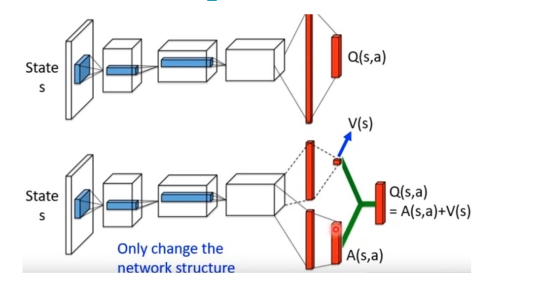

### discussion

### reference:
https://www.cnblogs.com/xxxxxxxxx/p/12034554.html



In [1]:
import numpy as np
import torch
from torch import nn, optim
import os
import matplotlib.pyplot as plt
from atari_wrappers import make_atari, wrap_deepmind,LazyFrames

In [2]:
# preprocess
def prepro(obs):
    """
    preprocess observation 
    [84,84,4]=>[4,84,84]
    """
    obs = obs._force().transpose(2,0,1)/255  # 0-255 => 0-1, [84,84,4] => [4,84,84]
    return obs

In [3]:
# net
import torch
from torch import nn
class Net(nn.Module):
    """
    Initialize a deep Q-learning network as described in
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    Arguments:
        in_channels: number of channel of input.
            i.e The number of most recent frames stacked together as describe in the paper
        out_num: number of action-value to output, one-to-one correspondence to action in game.
    """
    def __init__(self, in_channel=4, out_num=6):
        super(Net,self).__init__()
        # layer setting paramters
        layers = [32,64,64]
        # output_size = (input_size-kernel_size)/stride + 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel,layers[0],kernel_size=8,stride=4), # [batch,4,84,84]=>[batch,layers[0],20,20] 
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(layers[0],layers[1],kernel_size=4,stride=2), # [batch,layers[0],20,20]=>[batch,layers[1],9,9]
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(layers[1],layers[2],kernel_size=3,stride=1), # [batch,layers[1],9,9]=>[batch,layers[2],7,7]
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(7*7*layers[2], 512),
            nn.ReLU()
        )
        self.linear_value = nn.Linear(256, 1)  # value
        self.linear_a = nn.Linear(256, out_num) # advantage
#         self.linear2 = nn.linear(512, out_num)  # for target
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten
        x = x.reshape(x.size(0), -1)  # [batch, layers[2],7,7]=>[batch,layers[2]*7*7]
        x = self.linear1(x)  # [batch,-1]=>[batch,512]
        x_value = x[:,:256]  # half part for value fullconnect [batch,256]
        x_a = x[:,256:]      # half part for advantage fullconnect [batch,256]
        y_value = self.linear_value(x_value)
        y_a = self.linear_a(x_a)
        # y = F.softmax(y)  # turn to probability
        return y_value, y_a
pre_net = Net()
print(pre_net)

Net(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (linear1): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear_value): Linear(in_features=256, out_features=1, bias=True)
  (linear_a): Linear(in_features=256, out_features=6, bias=True)
)


In [4]:
class SumTree():
    data_point = 0  # data idx
    def __init__(self, capacity):
        self.capacity = capacity  # num of leaves
        self.tree = np.zeros(capacity*2-1)
        self.transition = np.zeros(capacity, dtype=object) # save data
        self.n_entries = 0
        
    def total_p(self):
        return self.tree[0]  # return the 0 node
        
    def add(self, p, data):
        # add data and priority
        # p: priority, data 
        idx = self.data_point + self.capacity -1
        self.transition[self.data_point] = data   # save data        
        self.data_point += 1
        if self.data_point >= self.capacity:
            self.data_point = 0            
        
        change = p - self.tree[idx]   
        self.tree[idx] = p            # save priority
        self.n_entries += 1   # count num of entries
        
        # propagation  update parents nodes
        p_idx = (idx-1)//2  # parent idx
        while True:           
            self.tree[p_idx] += change
            if p_idx != 0:
                p_idx = (p_idx-1)//2
            else:
                break
    
    def update(self,idx, p):
        # update tree
        change = p - self.tree[idx]
        self.tree[idx] = p  # change priority in leaves node        
        # update parents node
        p_idx = (idx-1)//2   #
        while True:            
            self.tree[p_idx] += change
            if p_idx != 0:
                p_idx = (p_idx-1)//2
            else:
                break
    
    def retrieve(self, p_idx, s):
        # search leaf idx for s        
        while True:
            l_idx = p_idx*2 + 1  # left child idx
            r_idx = l_idx +1     # right child idx  
            if l_idx >= self.capacity*2-1: # 其子节点超出，结点序号范围， 说明已经是叶子结点
                return p_idx 
            if self.tree[l_idx] >= s:
                p_idx = l_idx
            else:
                p_idx = r_idx
                s -= self.tree[l_idx]
            
    def get(self, s):
        # get a data and priority from tree and transition        
        # get idx of leaves
        idx = self.retrieve(0,s)
        priority = self.tree[idx]
        data_idx = idx - (self.capacity - 1)
        data = self.transition[data_idx]
        return idx, priority, data        

In [5]:
# memory buffer replay
class Memory_buffer_replay():
    beta = 0.4
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.
    def __init__(self, capacity, device):
        self.capacity = capacity
        self.sumtree = SumTree(self.capacity)
        self.device = device
        
        self.e = 0.01
        self.a = 0.6
        self.prio_max = 0.1
        
    def store_record(self, state, state_next, a, r, done):
        data = (state, state_next, a, r, done)
        priority = (np.abs(self.prio_max) + self.e) ** self.a #  proportional priority
        self.sumtree.add(priority, data) # save p, data in sumtree
        
    def sample(self, batchsz):
        if self.sumtree.total_p()==0:
            return None
        states, state_nexts, a_s, r_s, done_s = [],[],[],[],[]
        idxs, ps, isweights = [],[],[]  # idss, prioritys
        segment = self.sumtree.total_p()/batchsz
        
        self.beta = np.min([1., self.beta+self.beta_increment_per_sampling])
        min_prob = np.min(self.sumtree.tree[-self.capacity:])/self.sumtree.total_p()
        
        for i in range(batchsz):
            down_bound = i*segment
            up_bound = (i+1)*segment
            s = np.random.uniform(down_bound, up_bound)
            idx, p, data = self.sumtree.get(s) 
            
            state, state_next, a, r, done = data
            prob = p/self.sumtree.total_p()
            isweight = np.power(prob/min_prob, -self.beta)
            
            isweights.append(isweight)
            idxs.append(idx)
            ps.append(p)
            states.append(state)
            state_nexts.append(state_next)
            a_s.append(a)
            r_s.append(r)
            done_s.append(done)
        
        #from list to numpy
#         idxs, ps = np.array(idxs), np.array(ps)
        # function: list=> tensor
        list2tensor = lambda data: torch.from_numpy(np.array(data)).to(self.device)
        
        isweights = list2tensor(isweights)
        states, state_nexts = list2tensor(states), list2tensor(state_nexts)
        a_s, r_s, done_s = list2tensor(a_s), list2tensor(r_s), list2tensor(done_s)
        # isweights: tensor, idx:list, ps:list, states:tensor, as, rs, done_s:tensor
        return isweights, idxs, ps, states, state_nexts, a_s, r_s, done_s
    
    def update(self, idxs, errors):
        # update data priority
        self.prio_max = max(self.prio_max, max(np.abs(errors)))
        for i, idx in enumerate(idxs):
            p = (np.abs(errors[i]) + self.e) ** self.a
            self.sumtree.update(idx, p)

In [6]:
# DQN with priority
import torch.nn.functional as F
class DQN_priority():
    def __init__(self, args, env, load_model=False):        
        # use cuda
        cuda = True
        if cuda:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device('cpu')
            
        # env
        self.env = env
        self.n_actions = env.action_space.n
        self.dim_shape = env.observation_space.shape
        
        # hyperparams
        self.capacity = 100000
        self.decay = 0.99
        self.episodes = args.episodes
        self.log_interval = args.log_interval  # print state per log_interval epsisode
        self.save_interval = args.save_interval  # interval for save model 
        
        self.epilon_max = 1
        self.epilon_min = 0.01
        self.learning_start = 10000  # 装满10000 再开始
        self.epilon_decay = 30000
        
        # learn params
        self.lr = args.lr
        self.batchsz = args.batchsz
        self.iter =0
        self.iter_max = args.iter_max
        
        # build model
        self.eval_model = Net().to(self.device)
        self.tar_model = Net().to(self.device)  
        # load model
        if load_model:
            self.eval_model.load_state_dict(torch.load('dqn_priority.mdl'))
        self.tar_model.load_state_dict(self.eval_model.state_dict())
        # build optimizer
        self.optimizer = optim.RMSprop(self.eval_model.parameters(),lr=self.lr, eps=0.001, alpha=0.95)
#         self.optimizer = optim.Adam(self.eval_model.parameters(), self.lr)
#         self.cost_F = nn.MSELoss()
        
        # build memory buffer
        self.buffer = Memory_buffer_replay(self.capacity, self.device)
    
    def train(self):
        episodes = self.episodes
        losses = []
        rewards  = []
        
        # decay function explot ratio
        epilon_by_g_step = lambda step_idx:self.epilon_min + (self.epilon_max-self.epilon_min)*np.exp(-1*step_idx/self.epilon_decay)
        # global step
        global_step = 0
        
        for epis in range(episodes):
            state = self.env.reset()
            state = prepro(state) # [84,84,4]=>[4,84,84]
            reward_sum = 0
            loss_ = []
            # decay explot ratio
#             self.explot_ep = self.explot_ep_min + (self.explot_ep_max-self.explot_ep_min)*np.exp(-1*epis/50.)
            while True:
                # decay explot ratio
                epsilon = epilon_by_g_step(global_step)
                global_step += 1 
                act = self.make_action(state, epsilon) # choose action
                state_next, r, done, inf = self.env.step(act)
                state_next = prepro(state_next)
                reward_sum += r                
                # store data
                self.buffer.store_record(state, state_next, act, r, done)                
                if done:                    
                    rewards.append(reward_sum)
                    losses.append(np.mean(loss_))
                    break  # start another episode
                else:
                    state = state_next
            
                # learn model
                if self.buffer.sumtree.n_entries == self.learning_start:
                    print('#'*30 + 'start learning' + '#'*30)
                if self.buffer.sumtree.n_entries > self.learning_start:
                    loss = self.learn()
                    loss_.append(loss)
                else:
                    loss_.append(0)
                
            # print train state
            if epis%self.log_interval==0 and epis>0:
                #print(losses)
                print('global step:{}'.format(global_step-1),
                      'episode :{}/{}'.format(epis, self.episodes), 
                      'aver loss:{:.5f}'.format(np.mean(losses[-10:])), 
                      'aver reward:{:.5f}'.format(np.mean(rewards[-10:])),
                      'explot:{:.5f}'.format(epsilon)
                     )
            # save model
            if epis%self.save_interval==0 and epis>0:
                torch.save(self.eval_model.state_dict(),'dqn_priority.mdl')
        return losses, rewards
    
    def learn(self):
        # learn the model
        
        # get data,  idxs, ps : list. others tensor
        isweights, idxs, ps, state, state_next, act_s, r_s, done_s = self.buffer.sample(self.batchsz)        
        
        # pre
        eval_v,eval_a = self.eval_model(state.float())
        eval_v = eval_v.view(-1) # colum vector => row vector        
        eval_q = eval_v + eval_a.gather(1,act_s.unsqueeze(1).long()).squeeze(1) + eval_a.mean(1) #      
        eval_q = eval_q.squeeze(-1)  # [batch,1] => [batch]
        # compute label
        next_q_v, next_q_a = self.tar_model(state_next.float()) 
        next_q_v = next_q_v.view(-1)
        next_max_q = (next_q_v + next_q_a.max(1)[0] - next_q_a.mean(1)).detach() # torch.max() return [max_data, max_idx]
        next_max_q = next_max_q.squeeze(-1) 
        decay = torch.tensor(self.decay).float().to(self.device)
        tar_q = r_s.float() + decay*next_max_q
        tar_q = torch.where(done_s>0, r_s.float(), tar_q)  # Q_next = r when done is true
        
        #compute td-loss
        loss = F.smooth_l1_loss(eval_q, tar_q)
#         loss = torch.mean(isweights*torch.abs(eval_q - tar_q)) # loss expect input dim=[batch,1]
        # update buffer with error
        errors = (eval_q - tar_q).detach().cpu().tolist()
        self.buffer.update(idxs, errors)
        
        self.optimizer.zero_grad()
        loss.backward()
        # clip gradient
        for param in self.eval_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # update tar_model
        self.iter += 1
        if self.iter%self.iter_max==0:
            self.tar_model.load_state_dict(self.eval_model.state_dict())
        
        return loss.cpu().item() # ruturn mean loss
    
    def make_action(self, state, epsilon=None):
        state = torch.from_numpy(state).float()
        
        pre_q_v, pre_q_a = self.eval_model(state.unsqueeze(0).to(self.device))
        pre_q_a = pre_q_a.cpu().detach()
        
        #explot_ep = self.explot_ep_min + (self.explot_ep_max-self.explot_ep_min)*np.exp(-1*epis/20.)
        if epsilon==None:
            epsilon=self.epsion_min
        if np.random.uniform()< epsilon:
            action = np.random.choice(self.n_actions) # random choose action
        else:
            action = torch.argmax(pre_q_a)
            action = action.item()
        return action        


In [7]:
# argument
class Argument():
    def __init__(self):
        self.lr = 1e-3
        self.batchsz = 32
        
        self.episodes = 1000
        
        self.log_interval = 1 # print state per log_interval epsisode
        self.save_interval = 20  # interval for save model
        
        self.iter_max = 1000  # update tar_model interval

args = Argument()

In [ ]:
# main
import gym
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )

load_model = False
run_dqn = DQN_priority(args, env, load_model)
losses, rewards = run_dqn.train()

global step:1918 episode :1/1000 aver loss:0.00000 aver reward:-19.50000 explot:0.93869
global step:2808 episode :2/1000 aver loss:0.00000 aver reward:-19.66667 explot:0.91154
global step:3899 episode :3/1000 aver loss:0.00000 aver reward:-19.25000 explot:0.87934
global step:4659 episode :4/1000 aver loss:0.00000 aver reward:-19.60000 explot:0.85760
global step:5415 episode :5/1000 aver loss:0.00000 aver reward:-19.83333 explot:0.83650
global step:6411 episode :6/1000 aver loss:0.00000 aver reward:-19.71429 explot:0.80951
global step:7172 episode :7/1000 aver loss:0.00000 aver reward:-19.87500 explot:0.78949
global step:7930 episode :8/1000 aver loss:0.00000 aver reward:-20.00000 explot:0.77004
global step:8690 episode :9/1000 aver loss:0.00000 aver reward:-20.10000 explot:0.75103
global step:9508 episode :10/1000 aver loss:0.00000 aver reward:-20.40000 explot:0.73110
##############################start learning##############################


/home/ryzen/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


global step:10420 episode :11/1000 aver loss:0.00137 aver reward:-20.30000 explot:0.70950
global step:11419 episode :12/1000 aver loss:0.00498 aver reward:-20.20000 explot:0.68659
global step:12235 episode :13/1000 aver loss:0.00697 aver reward:-20.50000 explot:0.66844
global step:13199 episode :14/1000 aver loss:0.00835 aver reward:-20.40000 explot:0.64762
global step:14201 episode :15/1000 aver loss:0.00912 aver reward:-20.20000 explot:0.62667
global step:15136 episode :16/1000 aver loss:0.00959 aver reward:-20.40000 explot:0.60775
global step:16387 episode :17/1000 aver loss:0.00997 aver reward:-20.10000 explot:0.58334
global step:17145 episode :18/1000 aver loss:0.01024 aver reward:-20.10000 explot:0.56903
global step:17990 episode :19/1000 aver loss:0.01044 aver reward:-20.10000 explot:0.55350
global step:18748 episode :20/1000 aver loss:0.01065 aver reward:-20.10000 explot:0.53994
global step:19703 episode :21/1000 aver loss:0.00941 aver reward:-20.10000 explot:0.52334
global ste

global step:102193 episode :103/1000 aver loss:0.00028 aver reward:-18.50000 explot:0.04283
global step:103287 episode :104/1000 aver loss:0.00029 aver reward:-18.40000 explot:0.04165
global step:104376 episode :105/1000 aver loss:0.00029 aver reward:-18.30000 explot:0.04052
global step:105416 episode :106/1000 aver loss:0.00030 aver reward:-18.60000 explot:0.03948
global step:106477 episode :107/1000 aver loss:0.00030 aver reward:-18.70000 explot:0.03846
global step:107757 episode :108/1000 aver loss:0.00030 aver reward:-18.60000 explot:0.03727
global step:109035 episode :109/1000 aver loss:0.00030 aver reward:-18.70000 explot:0.03613
global step:110223 episode :110/1000 aver loss:0.00030 aver reward:-18.60000 explot:0.03512
global step:111244 episode :111/1000 aver loss:0.00030 aver reward:-18.80000 explot:0.03428
global step:112648 episode :112/1000 aver loss:0.00030 aver reward:-18.50000 explot:0.03317
global step:113758 episode :113/1000 aver loss:0.00030 aver reward:-18.70000 exp

global step:241353 episode :193/1000 aver loss:0.00034 aver reward:-15.90000 explot:0.01032
global step:243235 episode :194/1000 aver loss:0.00033 aver reward:-15.70000 explot:0.01030
global step:245256 episode :195/1000 aver loss:0.00032 aver reward:-15.00000 explot:0.01028
global step:247383 episode :196/1000 aver loss:0.00032 aver reward:-14.50000 explot:0.01026
global step:249333 episode :197/1000 aver loss:0.00031 aver reward:-14.30000 explot:0.01024
global step:251387 episode :198/1000 aver loss:0.00030 aver reward:-14.10000 explot:0.01023
global step:253011 episode :199/1000 aver loss:0.00030 aver reward:-14.60000 explot:0.01022
global step:255134 episode :200/1000 aver loss:0.00030 aver reward:-14.40000 explot:0.01020
global step:257122 episode :201/1000 aver loss:0.00029 aver reward:-13.90000 explot:0.01019
global step:259135 episode :202/1000 aver loss:0.00029 aver reward:-13.90000 explot:0.01018
global step:261405 episode :203/1000 aver loss:0.00029 aver reward:-13.50000 exp

global step:436555 episode :283/1000 aver loss:0.00018 aver reward:-10.40000 explot:0.01000
global step:439049 episode :284/1000 aver loss:0.00018 aver reward:-10.10000 explot:0.01000
global step:441689 episode :285/1000 aver loss:0.00018 aver reward:-10.20000 explot:0.01000
global step:444045 episode :286/1000 aver loss:0.00019 aver reward:-10.60000 explot:0.01000
global step:445995 episode :287/1000 aver loss:0.00019 aver reward:-11.10000 explot:0.01000
global step:448413 episode :288/1000 aver loss:0.00019 aver reward:-10.50000 explot:0.01000
global step:450670 episode :289/1000 aver loss:0.00019 aver reward:-11.10000 explot:0.01000
global step:453289 episode :290/1000 aver loss:0.00019 aver reward:-11.60000 explot:0.01000
global step:456289 episode :291/1000 aver loss:0.00020 aver reward:-10.60000 explot:0.01000
global step:458825 episode :292/1000 aver loss:0.00020 aver reward:-10.20000 explot:0.01000
global step:461847 episode :293/1000 aver loss:0.00020 aver reward:-9.50000 expl

global step:653139 episode :373/1000 aver loss:0.00023 aver reward:-11.70000 explot:0.01000
global step:656223 episode :374/1000 aver loss:0.00023 aver reward:-10.80000 explot:0.01000
global step:658618 episode :375/1000 aver loss:0.00022 aver reward:-10.80000 explot:0.01000
global step:660030 episode :376/1000 aver loss:0.00022 aver reward:-12.00000 explot:0.01000
global step:662082 episode :377/1000 aver loss:0.00022 aver reward:-12.20000 explot:0.01000
global step:664851 episode :378/1000 aver loss:0.00021 aver reward:-11.90000 explot:0.01000
global step:666474 episode :379/1000 aver loss:0.00021 aver reward:-11.90000 explot:0.01000
global step:669427 episode :380/1000 aver loss:0.00021 aver reward:-11.10000 explot:0.01000
global step:671958 episode :381/1000 aver loss:0.00021 aver reward:-11.10000 explot:0.01000
global step:673597 episode :382/1000 aver loss:0.00021 aver reward:-11.60000 explot:0.01000
global step:675580 episode :383/1000 aver loss:0.00021 aver reward:-12.40000 exp

global step:868484 episode :463/1000 aver loss:0.00029 aver reward:-8.30000 explot:0.01000
global step:871433 episode :464/1000 aver loss:0.00030 aver reward:-8.10000 explot:0.01000
global step:874021 episode :465/1000 aver loss:0.00030 aver reward:-7.90000 explot:0.01000
global step:876935 episode :466/1000 aver loss:0.00030 aver reward:-7.00000 explot:0.01000
global step:879732 episode :467/1000 aver loss:0.00030 aver reward:-6.40000 explot:0.01000
global step:881735 episode :468/1000 aver loss:0.00030 aver reward:-7.60000 explot:0.01000
global step:884795 episode :469/1000 aver loss:0.00030 aver reward:-7.10000 explot:0.01000
global step:887815 episode :470/1000 aver loss:0.00030 aver reward:-6.50000 explot:0.01000
global step:890699 episode :471/1000 aver loss:0.00030 aver reward:-6.30000 explot:0.01000
global step:893247 episode :472/1000 aver loss:0.00030 aver reward:-7.10000 explot:0.01000
global step:896145 episode :473/1000 aver loss:0.00031 aver reward:-8.00000 explot:0.01000

global step:1087285 episode :553/1000 aver loss:0.00072 aver reward:-13.20000 explot:0.01000
global step:1089471 episode :554/1000 aver loss:0.00073 aver reward:-13.20000 explot:0.01000
global step:1091292 episode :555/1000 aver loss:0.00074 aver reward:-13.60000 explot:0.01000
global step:1093505 episode :556/1000 aver loss:0.00075 aver reward:-13.10000 explot:0.01000
global step:1095850 episode :557/1000 aver loss:0.00076 aver reward:-12.70000 explot:0.01000
global step:1097885 episode :558/1000 aver loss:0.00077 aver reward:-12.70000 explot:0.01000
global step:1100311 episode :559/1000 aver loss:0.00076 aver reward:-12.60000 explot:0.01000
global step:1102193 episode :560/1000 aver loss:0.00076 aver reward:-13.20000 explot:0.01000
global step:1103955 episode :561/1000 aver loss:0.00076 aver reward:-12.70000 explot:0.01000
global step:1106080 episode :562/1000 aver loss:0.00077 aver reward:-13.30000 explot:0.01000
global step:1107789 episode :563/1000 aver loss:0.00078 aver reward:-1

global step:1261659 episode :642/1000 aver loss:0.00108 aver reward:-13.80000 explot:0.01000
global step:1263518 episode :643/1000 aver loss:0.00111 aver reward:-13.40000 explot:0.01000
global step:1265792 episode :644/1000 aver loss:0.00113 aver reward:-13.50000 explot:0.01000
global step:1267653 episode :645/1000 aver loss:0.00114 aver reward:-13.30000 explot:0.01000
global step:1269681 episode :646/1000 aver loss:0.00116 aver reward:-13.10000 explot:0.01000
global step:1271505 episode :647/1000 aver loss:0.00116 aver reward:-13.00000 explot:0.01000
global step:1273832 episode :648/1000 aver loss:0.00117 aver reward:-13.40000 explot:0.01000
global step:1275707 episode :649/1000 aver loss:0.00116 aver reward:-13.70000 explot:0.01000
global step:1277468 episode :650/1000 aver loss:0.00114 aver reward:-13.50000 explot:0.01000
global step:1279886 episode :651/1000 aver loss:0.00113 aver reward:-13.10000 explot:0.01000
global step:1281751 episode :652/1000 aver loss:0.00112 aver reward:-1

global step:1430095 episode :731/1000 aver loss:0.00193 aver reward:-12.20000 explot:0.01000
global step:1432514 episode :732/1000 aver loss:0.00190 aver reward:-12.40000 explot:0.01000
global step:1435479 episode :733/1000 aver loss:0.00190 aver reward:-11.70000 explot:0.01000
global step:1438005 episode :734/1000 aver loss:0.00194 aver reward:-11.00000 explot:0.01000
global step:1440746 episode :735/1000 aver loss:0.00197 aver reward:-10.20000 explot:0.01000
global step:1442963 episode :736/1000 aver loss:0.00199 aver reward:-10.50000 explot:0.01000
global step:1445041 episode :737/1000 aver loss:0.00199 aver reward:-10.30000 explot:0.01000
global step:1446711 episode :738/1000 aver loss:0.00197 aver reward:-11.00000 explot:0.01000
global step:1448502 episode :739/1000 aver loss:0.00195 aver reward:-11.70000 explot:0.01000
global step:1450236 episode :740/1000 aver loss:0.00193 aver reward:-11.90000 explot:0.01000
global step:1452696 episode :741/1000 aver loss:0.00191 aver reward:-1

global step:1652677 episode :820/1000 aver loss:0.00246 aver reward:-10.10000 explot:0.01000
global step:1655268 episode :821/1000 aver loss:0.00247 aver reward:-10.00000 explot:0.01000
global step:1658404 episode :822/1000 aver loss:0.00247 aver reward:-10.00000 explot:0.01000
global step:1661433 episode :823/1000 aver loss:0.00247 aver reward:-10.30000 explot:0.01000
global step:1663904 episode :824/1000 aver loss:0.00245 aver reward:-10.40000 explot:0.01000
global step:1666618 episode :825/1000 aver loss:0.00240 aver reward:-10.00000 explot:0.01000
global step:1669286 episode :826/1000 aver loss:0.00236 aver reward:-9.80000 explot:0.01000
global step:1671920 episode :827/1000 aver loss:0.00232 aver reward:-9.60000 explot:0.01000
global step:1675243 episode :828/1000 aver loss:0.00226 aver reward:-8.70000 explot:0.01000
global step:1677454 episode :829/1000 aver loss:0.00221 aver reward:-9.10000 explot:0.01000
global step:1680050 episode :830/1000 aver loss:0.00218 aver reward:-9.200

global step:1896029 episode :909/1000 aver loss:0.00231 aver reward:-7.70000 explot:0.01000
global step:1899066 episode :910/1000 aver loss:0.00238 aver reward:-7.50000 explot:0.01000
global step:1902179 episode :911/1000 aver loss:0.00243 aver reward:-7.20000 explot:0.01000
global step:1904699 episode :912/1000 aver loss:0.00249 aver reward:-7.90000 explot:0.01000
global step:1907908 episode :913/1000 aver loss:0.00254 aver reward:-7.40000 explot:0.01000
global step:1910081 episode :914/1000 aver loss:0.00259 aver reward:-8.40000 explot:0.01000
global step:1912964 episode :915/1000 aver loss:0.00263 aver reward:-8.00000 explot:0.01000
global step:1915571 episode :916/1000 aver loss:0.00269 aver reward:-7.90000 explot:0.01000
global step:1917729 episode :917/1000 aver loss:0.00273 aver reward:-9.00000 explot:0.01000
global step:1920244 episode :918/1000 aver loss:0.00279 aver reward:-9.80000 explot:0.01000
global step:1923015 episode :919/1000 aver loss:0.00283 aver reward:-9.70000 exp

In [ ]:
# plot loss and rewards
import matplotlib.pyplot as plt
def plot_(losses, rewards):
    plt.figure()
    plt.title('rewards')
    plt.plot(list(range(len(rewards))), rewards)
    
    plt.figure()
    plt.title('loss')
    plt.plot(list(range(len(losses))),losses)
    plt.show()

plot_(losses, rewards) 